Originally I wanted to adapt a model for predicting NCAA basket ball outcomes to the NHL. The model is called [Bayesian Logistic Regression Markov Chain (LRMC)](https://www2.isye.gatech.edu/~jsokol/lrmc/) and it works by treating the difference in points between two teams in any game as a normally distributed random variable which depends on the inherent difference in skill between the two teams plus a home court advantage added to the home team. The home court advantage is assumed to be constant across all teams. Unfortunately, when I originally explored this idea I discovered that the difference in score between two teams in each game would not be a good fit for a normal distribution, and so I concluded there wouldn't be an easy way to fit the LRMC model to the NHL.

Refusing to give up on this project, I started looking at other ways to model HHL games, and thought about trying to model them in PYMC3. This thought lead me to a PYMC3 example called [A Hierarchical model for Rugby prediction](https://docs.pymc.io/notebooks/rugby_analytics.html) by Peadar Coyle. That work was inspired by [Daniel Weitzenfeld](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/), which in turn was based on a model first developed by [Gianluca Baio and Marta A. Blangiardo](http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf). With the help of the above examples and papers, I was able to figure out the preceding models and adapt them to the NHL. Due to NHL rules which force a winner of every game by first going to a five minute sudden death overtime, and then to a shootout, I have also extended the model to calculate a tie-breaker random variable to determine the ultimate winner.

In [1]:
# Import all of the libraries needed for this post
import requests
import json
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import theano
from itertools import combinations

/home/everett/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Before we can dive into creating the model, we need to get some data. The functions below use the requests and json libraries to extract the data we need from the official NHL statistics API. I have written the data to CSV file so that it is possible to perform the rest of the analysis without constantly retrieving the data over the Internet.

In [2]:
# A function that retrieves the game data from the NHL stats API
# for a selected date range.
def request_game_data(start_date, end_date):
    base_url = 'https://statsapi.web.nhl.com'
    path = '/api/v1/schedule?startDate='+start_date+\
            '&endDate='+end_date+'&expand=schedule.linescore'
    response = requests.get(base_url + path)
    return response.json()

# A function to extract the relevant data from the schedule
# and return it as a pandas dataframe
def extract_game_data(schedule):
    """Given full JSON records for games from the NHL API,
    returns a simplified list of just the data we need.
    """
    games = pd.DataFrame(columns=['date',
                                  'season',
                                  'game_type',
                                  'home_team',
                                  'home_team_reg_score',
                                  'home_team_fin_score',
                                  'away_team',
                                  'away_team_reg_score',
                                  'away_team_fin_score',
                                  'went_to_shoot_out'
                                  ])

    for date_obj in schedule['dates']:
        date = date_obj['date'];
        for game_obj in date_obj['games']:
            game_type = game_obj['gameType']
            season = game_obj['season']
            home_team_obj = game_obj['teams']['home']
            away_team_obj = game_obj['teams']['away']

            home_team = home_team_obj['team']['name']
            home_team_fin_score = home_team_obj['score']

            away_team = away_team_obj['team']['name']
            away_team_fin_score = away_team_obj['score']

            detailed_score_data = game_obj['linescore']
            period_data = detailed_score_data['periods']

            home_team_reg_score = 0
            away_team_reg_score = 0

            for period in period_data[0:3]:
                home_team_reg_score += period['home']['goals']
                away_team_reg_score += period['away']['goals']

            went_to_shoot_out = detailed_score_data['hasShootout']

            games = games.append({'date': date,
                                  'season': season,
                                  'game_type': game_type,
                                  'home_team': home_team,
                                  'home_team_reg_score': home_team_reg_score,
                                  'home_team_fin_score': home_team_fin_score,
                                  'away_team': away_team,
                                  'away_team_reg_score': away_team_reg_score,
                                  'away_team_fin_score': away_team_fin_score,
                                  'went_to_shoot_out': went_to_shoot_out
                                  }, ignore_index=True)

    return games

completed_game_data = request_game_data('2017-09-18', '2018-12-24')
completed_games = extract_game_data(completed_game_data)
completed_games.to_csv('../data/raw/completed_games.csv', index = False)

scheduled_game_data = request_game_data('2018-12-25', '2019-01-31')
scheduled_games = extract_game_data(scheduled_game_data)
scheduled_games.to_csv('../data/raw/scheduled_games.csv', index = False)

In [3]:
completed_games.columns

Index(['date', 'season', 'game_type', 'home_team', 'home_team_reg_score',
       'home_team_fin_score', 'away_team', 'away_team_reg_score',
       'away_team_fin_score', 'went_to_shoot_out'],
      dtype='object')

It is necessary to also decorate this data with integer labels for the home and away teams. These labels serve as an array index for the random variables, and allow us to reference the correct random variables for each team in the PYMC3 model.

In [4]:
# Filter the data to just regular season games from the 2015-2016 and 
# 2016-2017 seasons 
completed_games = pd.read_csv('../data/raw/completed_games.csv')
completed_games = completed_games.loc[completed_games['game_type'] == 'R']

# Select the columns I need for this analysis
completed_games = completed_games[['home_team', 'away_team', 
                                   'home_team_reg_score', 
                                   'away_team_reg_score', 
                                   'home_team_fin_score', 
                                   'away_team_fin_score']]

# Extract the unique list of teams and assign an integer label to each one
teams = completed_games.home_team.unique()
teams = np.sort(teams)
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
    
# Determine if the ultimate winner of the game was the home team 
def game_outcome_to_bernoulli_data(row):
    return row['home_team_fin_score'] > row['away_team_fin_score']

# Modify the data to include team and pair integer labels
def add_team_data_labels(game_data):
    game_data = game_data.merge(teams, left_on='home_team', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_home'}).drop('team', axis=1)
    game_data = game_data.merge(teams, left_on='away_team', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_away'}).drop('team', axis=1)
    game_data['home_win'] = game_data.apply(game_outcome_to_bernoulli_data, axis=1)
    
    return game_data
    
completed_games = add_team_data_labels(completed_games)

Because the ultimate goal of this model is to make predictions about the outcomes for games that haven't been played yet we need to extract the data for the model into Theano shared variables as [described in the PYMC3 documentation](https://docs.pymc.io/advanced_theano.html). This will allow us to swap out the data for completed games with the scheduled games and then predict samples of game outcomes for those scheduled games too.

In [5]:
# Determine the total number of teams for PYMC3
num_teams = len(completed_games.i_home.drop_duplicates())

# Create shaed theano variables that can be swapped out with
# scheduled games later.
home_team = theano.shared(completed_games.i_home.values)
away_team = theano.shared(completed_games.i_away.values)

# Create arrays of observations for our pymc3 model
observed_home_goals = completed_games.home_team_reg_score.values
observed_away_goals = completed_games.away_team_reg_score.values
observed_home_winner = completed_games.home_win.values

In [6]:
observed_home_goals.shape

(1837,)

Now we can fit the PYMC3 model. The model assumes that goals scored in regulation time by the home and the away team can be modeled as Poisson distributed random variables, which we treat as observed random variables since we can see the number of goals that were scored. We also assume that the distribution of these variables is dependent on some inherent features of the teams such as their defensive and offensive skill, as well as other phenomenon not specific to teams such as home ice advantage and a constant intercept term. All of these are unobserved random variables that we expect to determine the Poisson distributions for goals scored in each game. Additionally, the tie breaker is modeled as a Bernoulli observed random variable which I have defined in terms of the same unobserved random variables that determines the Poisson distributed scores. Since overtime is sudden death, we can say the probability the home team wins in overtime is equal to the probability that they score before the away team does. It turns out that this Bernoulli variable can be parameterized in terms of exponentially distributed wait times, which share the same parameter as our existing Poisson distributed goal count distributions. [This video](https://www.youtube.com/watch?v=0g3pL4Y9MII) explains the math, however note that Gareth accidentally switches his parameters part way through and inadvertently calculates the compliment of the stated problem.

In [7]:
with pm.Model() as model:
    # Global model parameters
    home = pm.Flat('home')
    sd_offence = pm.HalfFlat('sd_offence') #pm.HalfStudentT('sd_offence', nu=3, sd=2.5)
    sd_defence = pm.HalfFlat('sd.offence') #pm.HalfStudentT('sd_defence', nu=3, sd=2.5)
    intercept = pm.Flat('intercept')

    # Team-specific poisson model parameters
    offence_star = pm.Normal('offence_star', mu=0, sd=sd_offence, shape=num_teams)
    defence_star = pm.Normal('defence_star', mu=0, sd=sd_defence, shape=num_teams)
    offence = pm.Deterministic('offence', offence_star - tt.mean(offence_star))
    defence = pm.Deterministic('defence', defence_star - tt.mean(defence_star))
    home_theta = tt.exp(intercept + home + offence[home_team] - defence[away_team])
    away_theta = tt.exp(intercept + offence[away_team] - defence[home_team])

    # OT/SO win bernoulli model parameters
    # https://www.youtube.com/watch?v=0g3pL4Y9MII
    # P(T < Y), where T ~ a, Y ~ b: a/(a + b)
    bernoulli_p_fn = home_theta/(home_theta + away_theta)
    
    # Likelihood of observed data
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=observed_home_goals)
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=observed_away_goals)
    tie_breaker = pm.Bernoulli('tie_breaker', p=bernoulli_p_fn, observed=observed_home_winner)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [defence_star, offence_star, intercept, sd.offence, sd_offence, home]
Sampling 3 chains: 100%|██████████| 15000/15000 [01:44<00:00, 143.21draws/s]


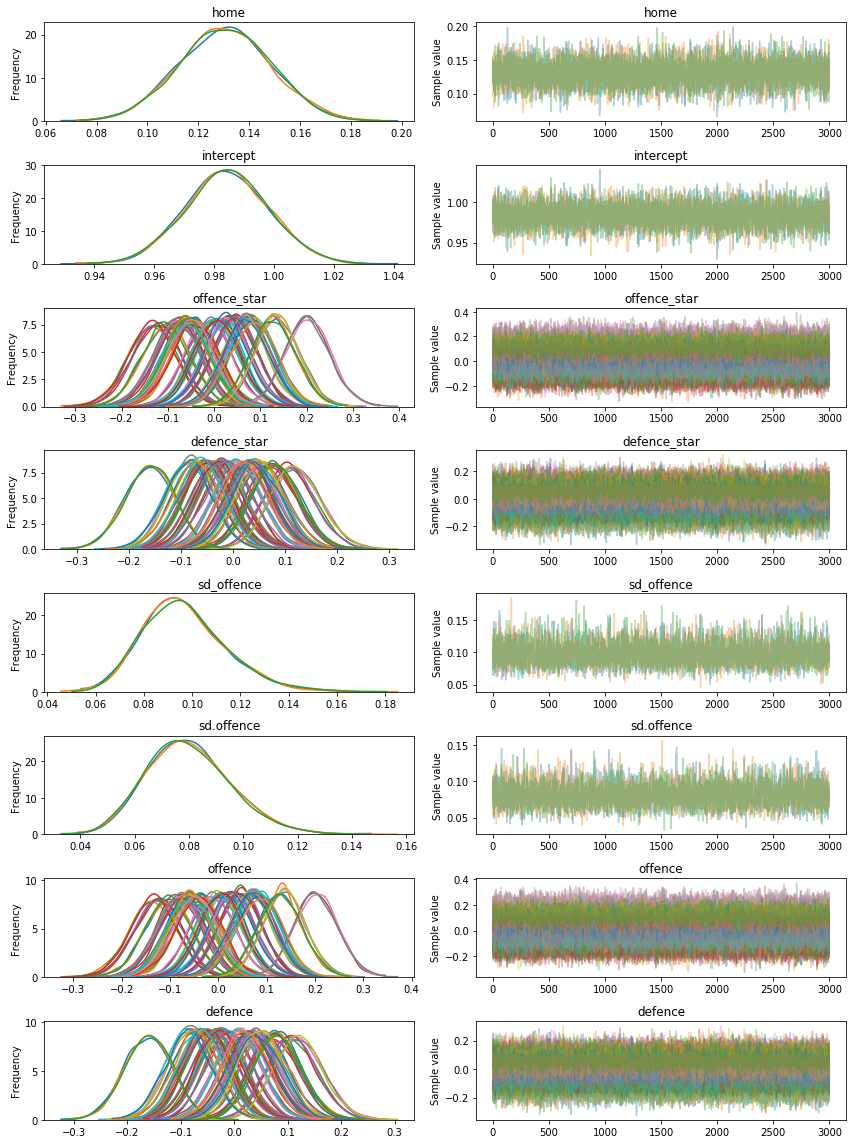

In [8]:
with model:
    trace = pm.sample(3000, tune=2000, cores=3)
    pm.traceplot(trace)

The trace plots make it appear as though the PYMC3 model has converged to the stationary distribution for each of the variables, suggesting that we do not need to adjust the burn-in period manually.

Next we can also look at the BFMI and Gelman-Rubin statistics:

In [9]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

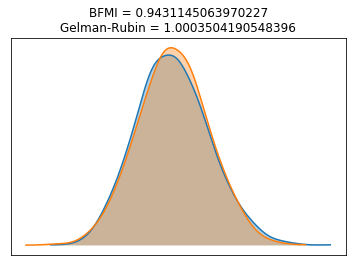

In [10]:
(pm.energyplot(trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

The [BFMI statistic is well above the threshold of 0.2](https://docs.pymc.io/api/stats.html) that is typically suggested by the PYMC3 and Stan projects for indicating poor sampling. Furthermore, the Gelman-Rubin statistic is very close to 1, which further suggests that convergence on the stationary distribution has occurred.

Satisfied that the PYMC3 model hasn't failed miserably, let's look at the posterior distributions for some of the unobserved random variables like team offensive and defensive strengths:

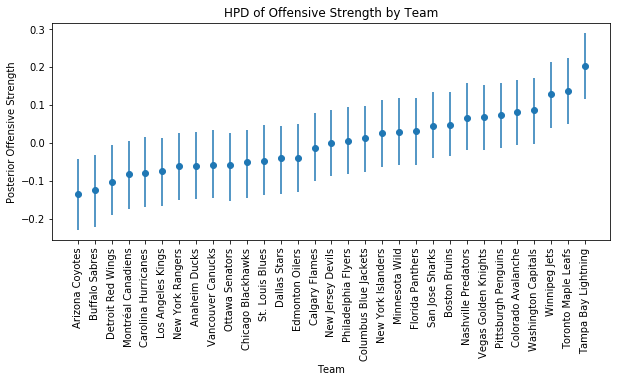

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

df_hpd = pd.DataFrame(pm.stats.hpd(trace['offence']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['offence'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Offensive Strength by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Offensive Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=90)

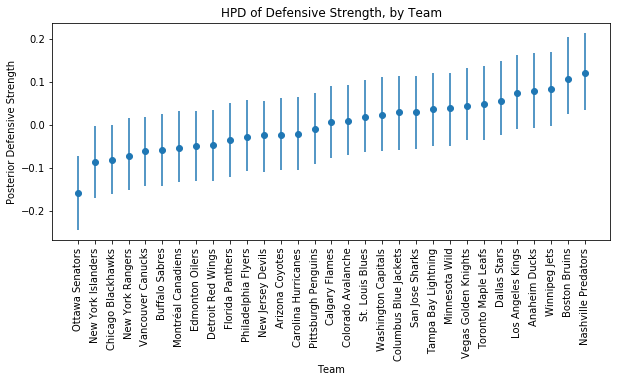

In [12]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['defence']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['defence'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Defensive Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defensive Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=90)

Now let's move on to the fun part and begin trying to predict outcomes for the remaining games.

In [13]:
scheduled_games = pd.read_csv('../data/raw/scheduled_games.csv')
scheduled_games = scheduled_games.loc[scheduled_games['game_type'] == 'R']

# Select the columns I need for this analysis
scheduled_games = scheduled_games[['home_team', 'away_team', 
                                   'home_team_reg_score', 'away_team_reg_score', 
                                   'home_team_fin_score', 'away_team_fin_score']]

scheduled_games = add_team_data_labels(scheduled_games)

# Swap theano variables with scheduled games.
home_team.set_value(scheduled_games.i_home.values)
away_team.set_value(scheduled_games.i_away.values)

In [14]:
with model:
    post_pred = pm.sample_ppc(trace)

/home/everett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 9000/9000 [00:34<00:00, 260.26it/s]


We can make sure that the shape of all our posterior predictions looks reasonable. There are 214 games being predicted on, and for our posterior predictions there are 2000 samples for each game, times 214 games.

In [15]:
print(scheduled_games.shape)
print(post_pred['away_goals'].shape)
print(post_pred['home_goals'].shape)
print(post_pred['tie_breaker'].shape)

(214, 9)
(9000, 214)
(9000, 214)
(9000, 214)


Let's look at how these simulations play out. For simplicity I will first examine a single game; the Calgary Flames vs the Winnipeg Jets in Winnipeg. I picked this game in particular since my father is a Flames fan, and this is the next game they will play. Let us start by looking at the predicted number of goals each team will score during regulation time:

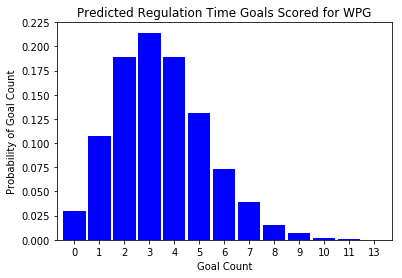

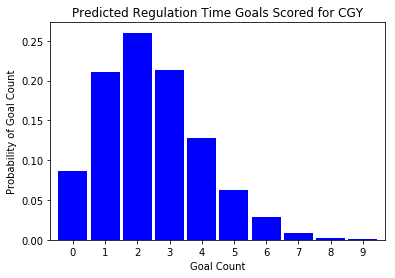

In [28]:
import matplotlib.pyplot as plt

def plot_posterior_goal_count(posterior_goals, team_name):
    fig = plt.figure()
    ax = fig.add_subplot()

    vc = pd.Series(posterior_goals).value_counts().sort_index()
    vc /= float(vc.sum())
    ax = vc.plot(kind='bar', width=0.9, color='b')

    ax.set_ylabel('Probability of Goal Count')
    ax.set_xlabel('Goal Count')
    ax.set_title('Predicted Regulation Time Goals Scored for {}'.format(team_name))
    
    fig = ax.get_figure()
    plt.xticks(rotation=0)
    plt.show()

plot_posterior_goal_count(post_pred['home_goals'][:,7], 'WPG')
plot_posterior_goal_count(post_pred['away_goals'][:,7], 'CGY')

In [29]:
# Determine all the games in which the home and away teams win, lose, 
# or tie in regulation time
home_won_regulation = post_pred['home_goals'] > post_pred['away_goals']
away_won_regulation = post_pred['away_goals'] > post_pred['home_goals']
regulation_tie = post_pred['home_goals'] == post_pred['away_goals']

# Determine which team utimately wins in the event of a tie
home_won_tie_breaker = post_pred['tie_breaker']
away_won_tie_breaker = ~home_won_tie_breaker

In [30]:
scheduled_game_probs = scheduled_games[['home_team', 'away_team']].copy()
scheduled_game_probs['home_regulation_win'] = home_won_regulation.mean(axis=0)
scheduled_game_probs['home_OT_SO_win'] = (regulation_tie & home_won_tie_breaker).mean(axis=0)
scheduled_game_probs['away_regulation_win'] = away_won_regulation.mean(axis=0)
scheduled_game_probs['away_OT_SO_win'] = (regulation_tie & away_won_tie_breaker).mean(axis=0)

scheduled_game_probs.loc[7, :]

home_team               Winnipeg Jets
away_team              Calgary Flames
home_regulation_win          0.582556
home_OT_SO_win              0.0885556
away_regulation_win          0.261111
away_OT_SO_win              0.0677778
Name: 7, dtype: object

In [31]:
flames_home = scheduled_game_probs['home_team'] == "Calgary Flames"
flames_away = scheduled_game_probs['away_team'] == "Calgary Flames"

scheduled_game_probs.loc[(flames_home | flames_away), :]

,home_team,away_team,home_regulation_win,home_OT_SO_win,away_regulation_win,away_OT_SO_win
7,Winnipeg Jets,Calgary Flames,0.582556,0.088556,0.261111,0.067778
30,Calgary Flames,Vancouver Canucks,0.527667,0.090444,0.310444,0.071444
43,Calgary Flames,San Jose Sharks,0.435778,0.085222,0.397667,0.081333
49,Detroit Red Wings,Calgary Flames,0.415111,0.085889,0.412000,0.087000
55,Boston Bruins,Calgary Flames,0.554778,0.096222,0.277222,0.071778
69,Philadelphia Flyers,Calgary Flames,0.460222,0.089556,0.369556,0.080667
88,Chicago Blackhawks,Calgary Flames,0.417667,0.081111,0.414000,0.087222
102,Calgary Flames,Colorado Avalanche,0.426556,0.084333,0.401667,0.087444
118,Calgary Flames,Florida Panthers,0.475556,0.089889,0.358000,0.076556
137,Calgary Flames,Arizona Coyotes,0.550778,0.096667,0.279444,0.073111
